# ***Market Trend Analysis***

# **Data Understanding & Preparation**-
Dataset source- yahoo finance dataset (public financial/ market dataset)



Data loading and initial exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("yahoo_set.csv")
df.head()
df.tail()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1258 non-null   object
 1   Open         1258 non-null   object
 2   High         1258 non-null   object
 3   Low          1258 non-null   object
 4   Close*       1258 non-null   object
 5   Adj Close**  1258 non-null   object
 6   Volume       1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1258,1258,1258,1258,1258,1258,1258
unique,1258,1258,1258,1255,1255,1255,1219
top,"May 01, 2018","24,117.29","24,117.29","35,290.12","32,798.40","32,798.40","301,750,000"
freq,1,1,1,2,2,2,3


**Data Preprocessing & Trend Visualization**-

In [ ]:
df = df.sort_values('Date')
df = df.reset_index(drop=True)


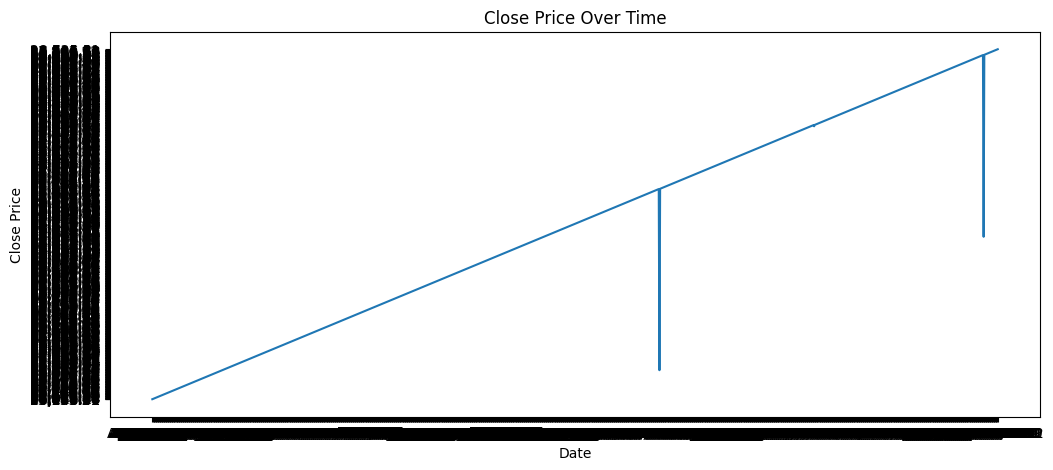

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close*'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


**Data Cleaning & Feature Formatting** -

In [ ]:
df.columns = df.columns.str.replace('*', '', regex=False)
df.columns = df.columns.str.replace(' ', '_')
df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume'], dtype='object')

In [ ]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume']

for col in numeric_cols:
    df[col] = (
        df[col]
        .astype(str)                # force everything to string
        .str.replace(',', '')       # remove commas
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convert to numeric
df.dtypes



,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Adj_Close,float64
Volume,int64


**Handling Missing Values & Date Formatting** -

In [ ]:
df.isnull().sum()


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj_Close,0
Volume,0


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.dtypes


,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Adj_Close,float64
Volume,int64


In [ ]:
df = df.sort_values('Date')
df = df.reset_index(drop=True)


# Analysis -

**Market Trend Analysis using Closing Price** -

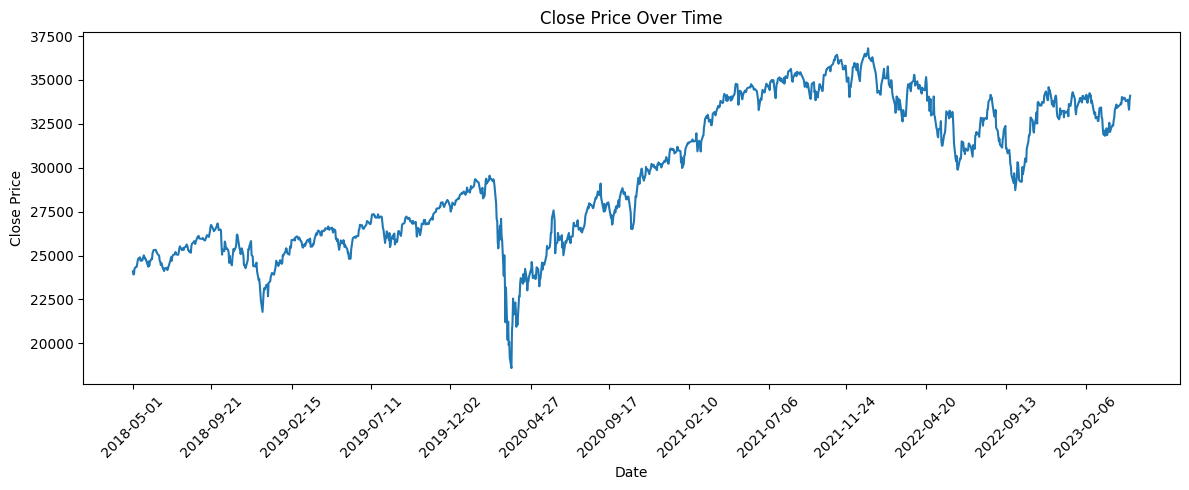

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'])
plt.title("Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.xticks(df['Date'][::100], rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
df['Close'].describe()
mean_close = df['Close'].mean()
median_close = df['Close'].median()

print("Mean Close Price:", mean_close)
print("Median Close Price:", median_close)


Mean Close Price: 29599.361677265504
Median Close Price: 29199.46


**Moving Average Analysis** -

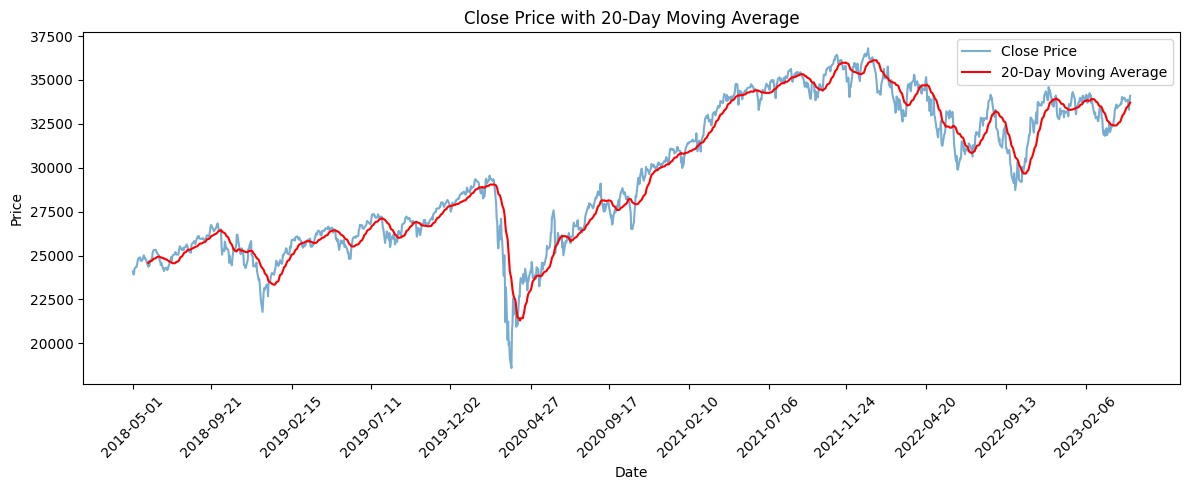

In [ ]:
df['MA_20'] = df['Close'].rolling(window=20).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Close'], label='Close Price', alpha=0.6)
plt.plot(df['Date'], df['MA_20'], label='20-Day Moving Average', color='red')
plt.title("Close Price with 20-Day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.xticks(df['Date'][::100], rotation=45)
plt.tight_layout()
plt.show()


**Volatility Analysis using Daily Returns** -

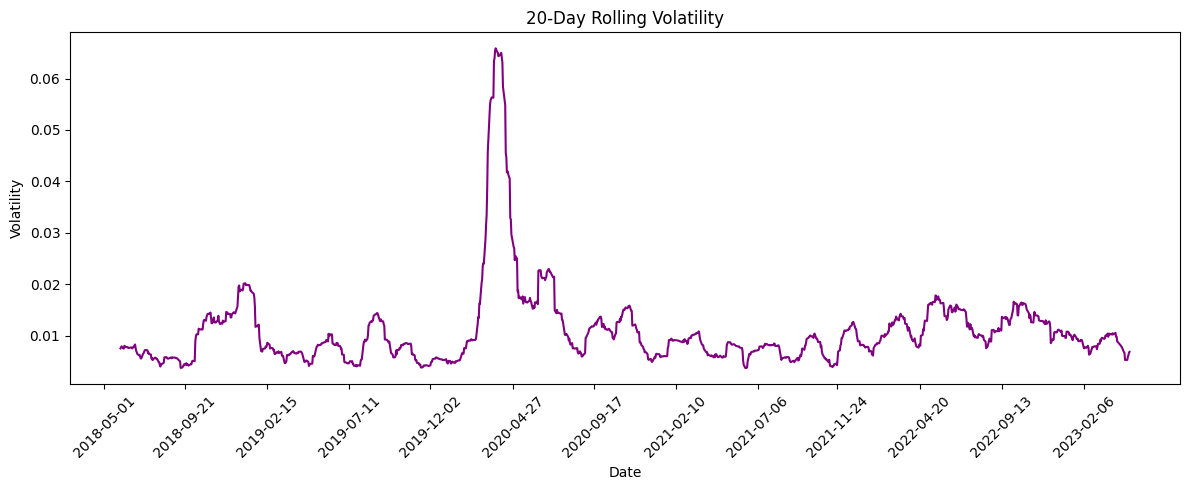

In [ ]:
df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()

plt.figure(figsize=(12,5))
plt.plot(df['Date'], df['Volatility_20'], color='purple')
plt.title("20-Day Rolling Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.xticks(df['Date'][::100], rotation=45)
plt.tight_layout()
plt.show()


**Trading Volume Analysis** -

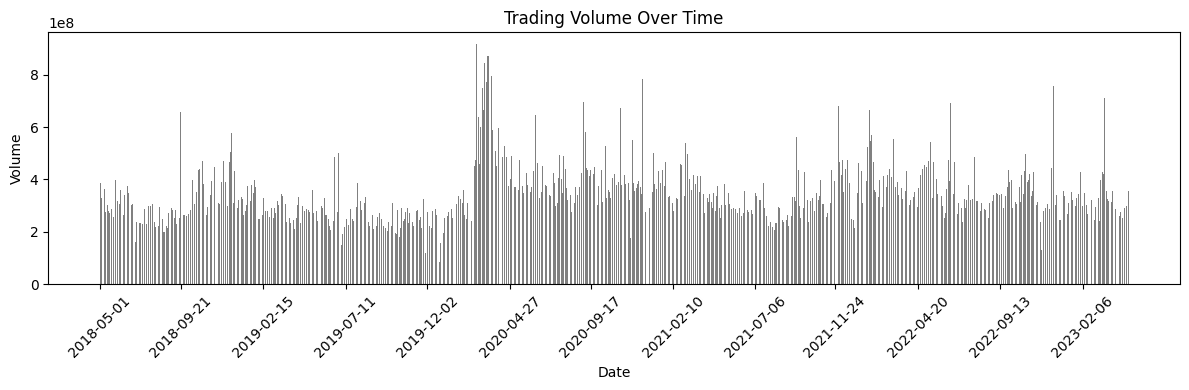

In [ ]:
plt.figure(figsize=(12,4))
plt.bar(df['Date'], df['Volume'], color='gray')
plt.title("Trading Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.xticks(df['Date'][::100], rotation=45)
plt.tight_layout()
plt.show()


**Feature Engineering for Market Trend Analysis** -

In [ ]:
df['Daily_Return'] = df['Close'].pct_change()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
df['Volatility_20'] = df['Daily_Return'].rolling(window=20).std()
df['High_Low_Range'] = df['High'] - df['Low']
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Close_Lag_1'] = df['Close'].shift(1)
df['Close_Lag_7'] = df['Close'].shift(7)
df = df.dropna()

In [ ]:
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1209 entries, 49 to 1257
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            1209 non-null   datetime64[ns]
 1   Open            1209 non-null   float64       
 2   High            1209 non-null   float64       
 3   Low             1209 non-null   float64       
 4   Close           1209 non-null   float64       
 5   Adj_Close       1209 non-null   float64       
 6   Volume          1209 non-null   int64         
 7   MA_20           1209 non-null   float64       
 8   Daily_Return    1209 non-null   float64       
 9   Volatility_20   1209 non-null   float64       
 10  MA_50           1209 non-null   float64       
 11  High_Low_Range  1209 non-null   float64       
 12  Momentum_5      1209 non-null   float64       
 13  Close_Lag_1     1209 non-null   float64       
 14  Close_Lag_7     1209 non-null   float64       
dtypes: datet

# Model/ System design

**Feature Selection and Scaling**-

In [ ]:
feature_df = df.drop(columns=['Date'])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(feature_df)


**Time-Series Sequence Generation** -

In [ ]:
def create_sequences(data, target_col_index, window_size=60):
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, target_col_index])

    return np.array(X), np.array(y)
target_col_index = feature_df.columns.get_loc('Close')
X, y = create_sequences(scaled_data, target_col_index, window_size=60)

In [ ]:
X.shape, y.shape


((1149, 60, 14), (1149,))

**Train–Test Split for Time-Series Data** -

In [ ]:
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Core Implementation

**LSTM Model Architecture Design** -

In [ ]:
import tensorflow as tf
import numpy as np
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

/usr/local/lib/python3.12/dist-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [ ]:
lstm_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(1)
])

In [ ]:
lstm_model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,185 (129.63 KB)

 Trainable params: 33,185 (129.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [ ]:
history = lstm_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 283ms/step - loss: 0.0281 - val_loss: 0.0099
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - loss: 0.0089 - val_loss: 0.0023
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 0.0074 - val_loss: 0.0019
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.0052 - val_loss: 0.0025
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0034 - val_loss: 0.0070
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 0.0034 - val_loss: 0.0087
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - 

**Model Training Strategy** -

# Evaluation & Analysis

**Training and Validation Loss Analysis** -

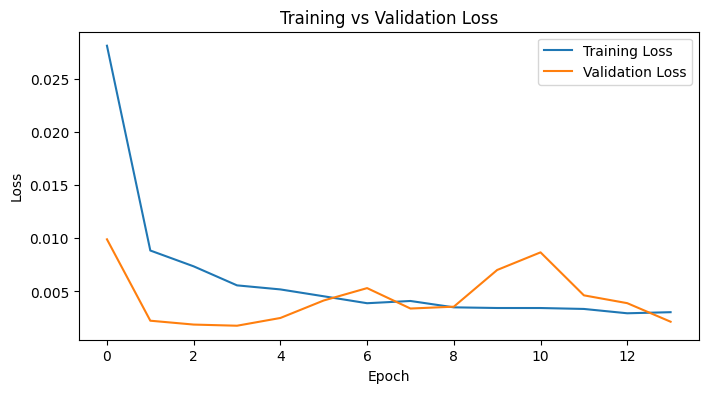

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


**Model Prediction on Test Data** -

In [ ]:
y_pred = lstm_model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


In [ ]:
import numpy as np

close_index = feature_df.columns.get_loc('Close')

dummy = np.zeros((len(y_pred), feature_df.shape[1]))
dummy[:, close_index] = y_pred.flatten()

y_pred_actual = scaler.inverse_transform(dummy)[:, close_index]
dummy_test = np.zeros((len(y_test), feature_df.shape[1]))
dummy_test[:, close_index] = y_test

y_test_actual = scaler.inverse_transform(dummy_test)[:, close_index]



**Actual vs Predicted Price Comparison** -

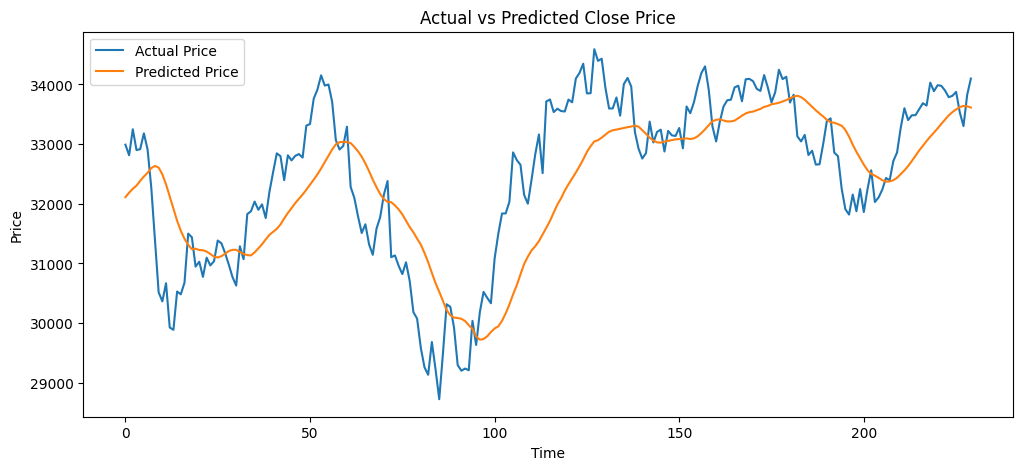

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(y_pred_actual, label='Predicted Price')
plt.title("Actual vs Predicted Close Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


**Trend Direction Inference** -

In [ ]:
price_change = y_pred_actual[-1] - y_test_actual[-1]

if price_change > 0:
    print("📈 Model predicts an UPWARD trend.")
else:
    print("📉 Model predicts a DOWNWARD trend.")


📉 Model predicts a DOWNWARD trend.


**Quantitative Performance Metrics** -

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 925.0246809693242
MAE: 751.5404360335913


# Insight Generation & Decision Support Layer

In [ ]:
def get_year_outlook(df, y_pred_actual, y_test_actual):
    """
    Provides a directional outlook (up/down/uncertain) for a future year
    based on recent learned patterns. Does NOT predict exact prices.
    """

    # Recent signals
    recent_trend = y_pred_actual[-1] - y_test_actual[-1]
    recent_momentum = df['Momentum_5'].iloc[-1]
    recent_volatility = df['Volatility_20'].iloc[-1]

    # Volatility threshold (heuristic)
    vol_threshold = df['Volatility_20'].mean()

    # Decision logic
    if recent_trend > 0 and recent_momentum > 0 and recent_volatility < vol_threshold:
        outlook = "Upward bias"
        confidence = "Moderate"

    elif recent_trend < 0 and recent_momentum < 0 and recent_volatility > vol_threshold:
        outlook = "Downward bias"
        confidence = "Low (high uncertainty)"

    else:
        outlook = "Sideways / Uncertain"
        confidence = "Low"

    explanation = (
        f"The model is trained on historical data up to the most recent period and "
        f"is designed for short-term forecasting. While exact price prediction for a future year "
        f"is not reliable, recent trends, momentum, and volatility suggest a **{outlook}** "
        f"with **{confidence} confidence**."
    )

    return {
        "outlook": outlook,
        "confidence": confidence,
        "explanation": explanation
    }


In [ ]:
def get_statistical_insights(df):
    return {
        "mean": df['Close'].mean(),
        "median": df['Close'].median(),
        "mode": df['Close'].round().mode().iloc[0],
        "std_dev": df['Close'].std(),
        "min": df['Close'].min(),
        "max": df['Close'].max(),
        "percentiles": {
            "25%": df['Close'].quantile(0.25),
            "50%": df['Close'].quantile(0.50),
            "75%": df['Close'].quantile(0.75)
        }
    }


In [ ]:
def get_trend_insight(y_pred_actual, y_test_actual):
    change = y_pred_actual[-1] - y_test_actual[-1]

    if change > 0:
        return "Upward trend expected in the near term."
    else:
        return "Downward trend expected in the near term."


In [ ]:
def get_volatility_insight(df):
    recent_vol = df['Volatility_20'].iloc[-1]
    avg_vol = df['Volatility_20'].mean()

    if recent_vol > avg_vol:
        return "Market is currently volatile. Higher risk observed."
    else:
        return "Market volatility is relatively low. Stable conditions."


In [ ]:
def get_forecast_summary(y_pred_actual, y_test_actual):
    diff = y_pred_actual[-1] - y_test_actual[-1]

    return {
        "expected_change": diff,
        "direction": "Up" if diff > 0 else "Down"
    }


In [ ]:
def insight_engine(df, y_pred_actual, y_test_actual):
    return {
        "statistics": get_statistical_insights(df),
        "trend": get_trend_insight(y_pred_actual, y_test_actual),
        "volatility": get_volatility_insight(df),
        "forecast": get_forecast_summary(y_pred_actual, y_test_actual),
        "year_outlook": get_year_outlook(df, y_pred_actual, y_test_actual)
    }


# Intent Classification using Transformer Model

In [ ]:
!pip install transformers datasets accelerate --quiet


In [ ]:
import torch
import pandas as pd
import numpy as np

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)


**Intent Label Definition and Mapping** -

In [ ]:
INTENT_LABELS = {
    "mean": 0,
    "median": 1,
    "mode": 2,
    "stats": 3,
    "trend": 4,
    "volatility": 5,
    "forecast": 6,
    "year": 7
}

ID2LABEL = {v: k for k, v in INTENT_LABELS.items()}


**Intent Dataset Construction** -

In [ ]:
intent_data = [

# ===================== MEAN =====================
("What is the mean price?", "mean"),
("Show the average closing price", "mean"),
("Tell me the average value", "mean"),
("Give me the mean of prices", "mean"),
("Average price analysis", "mean"),
("Mean market price", "mean"),
("What is the typical price?", "mean"),
("Show mean price graph", "mean"),
("Average of closing prices", "mean"),
("Calculate the mean price", "mean"),
("Mean value of market", "mean"),
("Average trend price", "mean"),
("Overall average price", "mean"),
("What is the average market level?", "mean"),
("Mean closing value", "mean"),
("Average price chart", "mean"),

# ===================== MEDIAN =====================
("What is the median price?", "median"),
("Show middle price", "median"),
("Tell me the median value", "median"),
("Median of closing prices", "median"),
("Middle price analysis", "median"),
("What is the mid price?", "median"),
("Median market value", "median"),
("Show median price chart", "median"),
("Middle value of prices", "median"),
("Find the median price", "median"),
("Median level of market", "median"),
("Middle point price", "median"),
("Median trend price", "median"),
("What is the central price?", "median"),
("Median closing value", "median"),
("Median price graph", "median"),

# ===================== MODE =====================
("What is the most frequent price?", "mode"),
("Show mode of prices", "mode"),
("Most common price value", "mode"),
("Mode of closing prices", "mode"),
("Which price occurs most?", "mode"),
("Frequent price level", "mode"),
("Mode price analysis", "mode"),
("Most repeated price", "mode"),
("Common market price", "mode"),
("Price that appears most", "mode"),
("Most frequent market value", "mode"),
("Mode of price distribution", "mode"),
("Dominant price level", "mode"),
("Most common closing price", "mode"),
("Mode price chart", "mode"),
("Frequent value in prices", "mode"),

# ===================== STATS =====================
("Give me statistical summary", "stats"),
("Show market statistics", "stats"),
("Summarize the data", "stats"),
("Give full statistics", "stats"),
("Describe price distribution", "stats"),
("Statistical analysis of prices", "stats"),
("Market data summary", "stats"),
("Show all statistics", "stats"),
("Give descriptive statistics", "stats"),
("Price statistics overview", "stats"),
("Statistical report of market", "stats"),
("Data summary of prices", "stats"),
("Market stats information", "stats"),
("Overall statistics", "stats"),
("Show summary statistics", "stats"),
("Price distribution summary", "stats"),

# ===================== TREND =====================
("What is the market trend?", "trend"),
("Is the market going up or down?", "trend"),
("Tell me the direction", "trend"),
("Trend analysis", "trend"),
("Market direction", "trend"),
("Is the trend bullish or bearish?", "trend"),
("Price movement direction", "trend"),
("Overall trend of market", "trend"),
("Which way is the market moving?", "trend"),
("Current market direction", "trend"),
("Upward or downward trend?", "trend"),
("Trend of prices", "trend"),
("Direction of market movement", "trend"),
("Is the market rising or falling?", "trend"),
("Short term trend", "trend"),
("Trend forecast", "trend"),

# ===================== VOLATILITY =====================
("Is the market volatile?", "volatility"),
("How risky is the market?", "volatility"),
("Tell me about volatility", "volatility"),
("Market risk analysis", "volatility"),
("Is the market unstable?", "volatility"),
("Volatility of prices", "volatility"),
("Risk level of market", "volatility"),
("Price fluctuations risk", "volatility"),
("How unstable is the market?", "volatility"),
("Market uncertainty level", "volatility"),
("Volatile market conditions", "volatility"),
("Risk assessment of prices", "volatility"),
("How much do prices fluctuate?", "volatility"),
("Market instability analysis", "volatility"),
("Volatility trend", "volatility"),
("Risk in current market", "volatility"),

# ===================== FORECAST =====================
("Predict next price", "forecast"),
("What will happen tomorrow?", "forecast"),
("Give short term prediction", "forecast"),
("Forecast next movement", "forecast"),
("Next day price prediction", "forecast"),
("Short term forecast", "forecast"),
("Predict near future price", "forecast"),
("What is expected next?", "forecast"),
("Tomorrow market prediction", "forecast"),
("Upcoming price forecast", "forecast"),
("Near term outlook", "forecast"),
("Price prediction for next day", "forecast"),
("Short horizon forecast", "forecast"),
("Next movement prediction", "forecast"),
("Immediate forecast", "forecast"),
("What comes next in price?", "forecast"),

# ===================== YEAR =====================
("What about 2024?", "year"),
("Long term outlook", "year"),
("What do you expect next year?", "year"),
("Future market outlook", "year"),
("Year wise expectation", "year"),
("What about upcoming year?", "year"),
("Long horizon outlook", "year"),
("Next year market direction", "year"),
("Outlook for coming year", "year"),
("Future year trend", "year"),
("Long term market direction", "year"),
("Year level forecast", "year"),
("Market view for next year", "year"),
("What to expect in future?", "year"),
("Future market direction", "year"),
("Long term perspective", "year"),
]


**Tokenization and Dataset Preparation** -

In [ ]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset
import pandas as pd

tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)
df_intents = pd.DataFrame(intent_data, columns=["text", "intent"])
df_intents["label"] = df_intents["intent"].map(INTENT_LABELS)

dataset = Dataset.from_pandas(df_intents[["text", "label"]])
tokenized_dataset = dataset.map(tokenize, batched=True)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/128 [00:00<?, ? examples/s]

**Transformer Model Training** -

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(INTENT_LABELS),
    id2label=ID2LABEL,
    label2id=INTENT_LABELS
)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./intent_model",
    per_device_train_batch_size=8,
    num_train_epochs=5,   # increased
    learning_rate=2e-5,
    logging_steps=10,
    save_strategy="no",
    report_to="none"
)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,2.082300
20,2.047600
30,1.934700
40,1.833100
50,1.719800
60,1.642400
70,1.595700
80,1.510000


TrainOutput(global_step=80, training_loss=1.795709490776062, metrics={'train_runtime': 138.8015, 'train_samples_per_second': 4.611, 'train_steps_per_second': 0.576, 'total_flos': 1821621626880.0, 'train_loss': 1.795709490776062, 'epoch': 5.0})

**Intent Prediction and Refinement Logic** -

In [ ]:
def predict_intent(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)

    predicted_id = torch.argmax(outputs.logits, dim=1).item()
    return ID2LABEL[predicted_id]


In [ ]:
def refine_stat_intent(query, predicted_intent):
    q = query.lower()

    if predicted_intent in ["mean", "median", "mode"]:
        if "average" in q or "mean" in q:
            return "mean"
        if "median" in q or "middle" in q:
            return "median"
        if "mode" in q or "frequent" in q or "most common" in q:
            return "mode"

    return predicted_intent


**Chatbot Response Generation** -

In [ ]:
def chatbot_answer(query, df, y_pred_actual, y_test_actual):
    raw_intent = predict_intent(query)
    intent = refine_stat_intent(query, raw_intent)

    insights = insight_engine(df, y_pred_actual, y_test_actual)

    if intent == "mean":
        return f"Mean Close Price: {insights['statistics']['mean']:.2f}"

    elif intent == "median":
        return f"Median Close Price: {insights['statistics']['median']:.2f}"

    elif intent == "mode":
        return f"Mode Close Price: {insights['statistics']['mode']:.2f}"

    elif intent == "trend":
        return insights["trend"]

    elif intent == "volatility":
        return insights["volatility"]

    elif intent == "forecast":
        return insights["forecast"]

    elif intent == "year":
        return insights["year_outlook"]["explanation"]

    else:
        return "I can help with market trends, statistics, volatility, and forecasts."


**Sample Chatbot Interactions** -
This chatbot is designed for analytical and educational purposes only and does not provide financial or investment advice.

In [ ]:
queries = [
    "Can you show me the average price?",
    "What is the most frequent price?",
    "Show median price graph",
    "Tell me the market direction",
    "How risky is the market now?",
    "What do you think about 2024?"
]

for q in queries:
    print(q, "→", chatbot_answer(q, df, y_pred_actual, y_test_actual))


Can you show me the average price? → Mean Close Price: 29799.68
What is the most frequent price? → Mode Close Price: 25064.00
Show median price graph → Median Close Price: 29551.42
Tell me the market direction → Downward trend expected in the near term.
How risky is the market now? → Market volatility is relatively low. Stable conditions.
What do you think about 2024? → The model is trained on historical data up to the most recent period and is designed for short-term forecasting. While exact price prediction for a future year is not reliable, recent trends, momentum, and volatility suggest a **Sideways / Uncertain** with **Low confidence**.


# Model Persistence & Artifact Saving

In [ ]:
lstm_model.save("lstm_marketmodel.keras")



In [ ]:
nlp_model = model
nlp_model.save_pretrained("intent_nlp_model")
tokenizer.save_pretrained("intent_nlp_model")


('intent_nlp_model/tokenizer_config.json',
 'intent_nlp_model/special_tokens_map.json',
 'intent_nlp_model/vocab.txt',
 'intent_nlp_model/added_tokens.json',
 'intent_nlp_model/tokenizer.json')

In [ ]:
import os
os.listdir("intent_nlp_model")


['tokenizer_config.json',
 'config.json',
 'model.safetensors',
 'tokenizer.json',
 'special_tokens_map.json',
 'vocab.txt']

In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:
import os

os.listdir(".")


['.config',
 'intent_model',
 'intent_nlp_model',
 'lstm_market_model.keras',
 'logs.txt',
 'lstm_marketmodel.keras',
 'scaler.pkl',
 'yahoo_set.csv',
 '.ipynb_checkpoints',
 'yahoo_clean_final.csv',
 'sample_data']

In [ ]:
clean_csv_name = "yahoo_clean_final.csv"
df.to_csv(clean_csv_name, index=False)

print(f"Saved cleaned dataset as {clean_csv_name}")


Saved cleaned dataset as yahoo_clean_final.csv


In [ ]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.20.0
Keras version: 3.13.0


The front-end of this project is uploaded as a .py file in github repo because the streamlit frontend if uploaded here, was too slow as the csv files were not being shown here.

Thank you.